<h1>Projket ekonometrtia</h1>
<h2>Uczelnia itd</h2>
<h2>Mateusz Jakubczak</h2>


Cytowania 

@inproceedings{seabold2010statsmodels,
  title={statsmodels: Econometric and statistical modeling with python},
  author={Seabold, Skipper and Perktold, Josef},
  booktitle={9th Python in Science Conference},
  year={2010},
}



<h3>Abstrakt cell projektu, hipoteza badawcza 



<h3>Pobieranie danych


In [2]:
import requests
from bs4 import BeautifulSoup
import re
import csv
import os
import unicodecsv
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from dython.nominal import associations
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
import statsmodels

In [3]:
#pare zmiennych globalnych 


with open("linki.csv",newline="") as csvfile:
    reader = csv.reader(csvfile)
    links2 = list(reader)

#unpack list of list to list
links =  [item for sublist in links2[1:] for item in sublist]

znaczniki ={"Cena":"_1svub _lf05o _9a071_2MEB_"}

lista_parametrów = ["Cena","Stan","Typ telewizora","Marka",
                    "Technologia 3D", "Przekątna ekranu",
                    "Format HD","Rozdzielczość ekranu",
                    "Liczba złączy HDMI", "Technologia HDR",
                    "Klasa efektywności","Pobór mocy",
                    "Waga produktu"
                    ]


#with open(os.path.join(os.getcwd(), 'parametry.csv'), 'wb') as csvfile:
 #   writer = unicodecsv.DictWriter(csvfile, fieldnames = lista_parametrów , delimiter = ';')
  #  writer.writeheader()
    

In [179]:
# for link in links:
#     parmaetry = []
#     response = requests.get(link)
#    # print(response)
#     
#     # znalazeinei ceny 
#     soup = BeautifulSoup(response.content,'html.parser')
#     #nalezalo by zastapic lepszym wyszukaniem
#     try:
#         cena = soup.find(class_=znaczniki["Cena"] )
#         # przejsc do dolu dwa razy po pierwszym elemencie 
#         cena = cena.contents[0].contents[0]
#     except:
#         AttributeError
#         print(link)
#         continue
#     parmaetry.append(cena)
#     #zanjdowanie tabeli parametrow 
#     pattern = re.compile(r'Parametry')
#     tabela = soup.find("h2",text= pattern)
#     #do gory dwa poziomy 
#     tabela = tabela.parent.parent
#    
#     for param in lista_parametrów[1:]:
#         try:
#             #najpier znajdz czy jest pole ktore nazywa sie dokladnie tak
#             stan_field = tabela.find(text = param)
#             #jesli nie ma takiego pola znajdz pierwsze które nazywa sie podobnie
#             if stan_field == None:  stan_field = tabela.find(text = re.compile(rf"{param}"))
#             #jesli nie znalioziona to wpisac -1
#             if stan_field == None: stan_field = -1
#             #up two nodes in tree then select content of second one
#             stan_field = stan_field.parent.parent.contents[1].contents[0]
#             try:
#                 if stan_field.contents != None : stan_field = stan_field.contents[0]
#             except:
#                 AttributeError   #dla pól co zawieraja w sobie linka 
#         except:
#             AttributeError 
#             print(f"Nie ma takiego parametru, parametr {param}") 
#             stan_field = -1
#         parmaetry.append(stan_field)
#     with open('parametry.csv', 'ab') as csvfile:
#         writer = unicodecsv.DictWriter(csvfile, fieldnames = lista_parametrów , delimiter = ';')
#         writer.writerow(dict(zip(lista_parametrów,parmaetry)))



In [7]:
def print(*args):
    __builtins__.print(*("%.2f" % a if isinstance(a, float) else a
                         for a in args))

<h3>Pre-processing and cleaning 

In [19]:
df = pd.read_csv("parametry.csv",delimiter=";")

print(df.dtypes)
#Cleaning
df["Cena"] = df["Cena"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Cena"] = df["Cena"].apply(pd.to_numeric)

#dla technoligi 3d w przypdako brakow zakladmy "nie" oraz zmiana do postaci binarnej 
df["Technologia 3D"] = df["Technologia 3D"].apply(lambda s : "nie" if s != "tak" else s)
df["Technologia 3D"] = df["Technologia 3D"].map({'tak': True, 'nie': False})
df["Technologia 3D"] = df["Technologia 3D"].astype('category')

#zmeinic przekonte na zmienna ciagłą 
df["Przekątna ekranu"] = df["Przekątna ekranu"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Przekątna ekranu"] = df["Przekątna ekranu"].apply(pd.to_numeric)

#polaczyc rozdzielczosc i format hd, poniewaz sa to pojecia rownowazne
#na niektorych ofertach jest podane tylko jedno 
print("Macierz czestości dla jakosci obrazu")
print(pd.crosstab(df["Rozdzielczość ekranu"],df["Format HD"]))
#potwierdza to macierz czestosci 
slownik =   {'3840 x 2160': '4K UHD',
             '7680 x 4320': '8K UHD',
             '1920 x 1080': 'Full HD',
             '1366 x 768': 'HD Ready'}
#first join
df['jakosc'] = df[[ 'Format HD','Rozdzielczość ekranu']].agg(';'.join, axis=1)
#then do operation on string
df['jakosc'] = df['jakosc'].apply(
    lambda s: s.split(sep = ";")[0] if s.split(sep = ";")[0] != "-1" and s.split(sep = ";")[0] != "inny"
    else slownik[s.split(sep = ";")[1]])
df["jakosc"]=df["jakosc"].astype('category')

#zmienic liczbe zleczy hdmi na categorical 
#mamy tutaj cztery mozliwe wartosci 
df["Liczba złączy HDMI"]=df["Liczba złączy HDMI"].astype('category')

#dla braku technologi HDR dac Nie 
df["Technologia HDR"] =df["Technologia HDR"].apply(lambda s: s if s != "-1" else "Nie")
df["Technologia HDR"]=df["Technologia HDR"].astype('category')

#klasy efektrywnosci -1 zamienic na inna 
df["Klasa efektywności"] = df["Klasa efektywności"].apply(lambda s: s if s != "-1" else "inna").astype("category")

#przeksztalcic pobor mocy do zmeinnej ciaglej 
df["Pobór mocy"] = df["Pobór mocy"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Pobór mocy"] = df["Pobór mocy"].apply(pd.to_numeric)

# usunac wage produktu, pozniewaz brakuje polowych danych 
print( df["Waga produktu"].value_counts("-1")[0], " telewizorow nie ma podanej swojej wagi")
df.drop(["Waga produktu", "Rozdzielczość ekranu","Format HD"], axis=1 , inplace=True)

#podstawowe zmiany 
df["Stan"] = df["Stan"].astype('category')
df["Typ telewizora"] = df["Typ telewizora"].astype('category')

#marka dla malo papularne zastapic inną,(mało popularna znaczy ze ilosc ofert danej marki jest mniejsza od mediany dla marki)
count = df["Marka"].value_counts()
popular = count > count.mean()
df["Marka"] = df["Marka"].apply(lambda row: row if popular[row] else "inna").astype("category")

Cena                    object
Stan                    object
Typ telewizora          object
Marka                   object
Technologia 3D          object
Przekątna ekranu        object
Format HD               object
Rozdzielczość ekranu    object
Liczba złączy HDMI       int64
Technologia HDR         object
Klasa efektywności      object
Pobór mocy              object
Waga produktu           object
dtype: object
Macierz czestości dla jakosci obrazu
Format HD             -1  4K UHD  8K UHD  Full HD  HD Ready  inny
Rozdzielczość ekranu                                             
1366 x 768             2       0       0        0        12     2
1920 x 1080            4       0       0       18         0     0
3840 x 2160            2      34       0        0         0     0
7680 x 4320            0       0       5        0         0     0
inna                   0       0       0        0         2     0
0.46  telewizorow nie ma podanej swojej wagi


<h3>Statytyki opisowe 

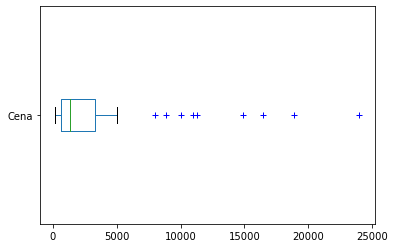

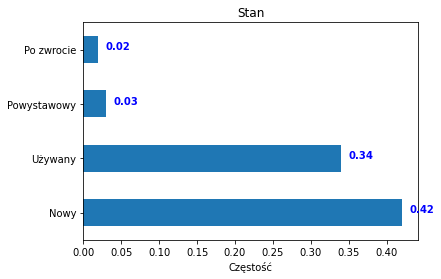

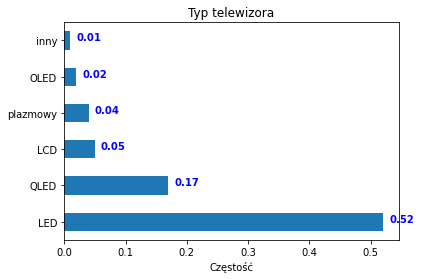

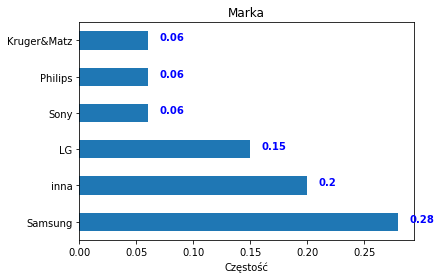

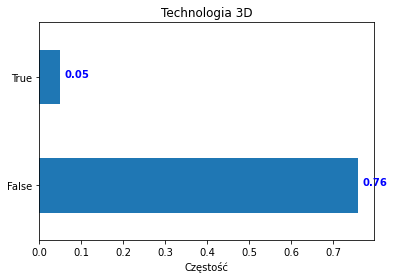

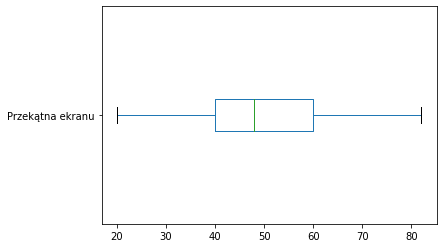

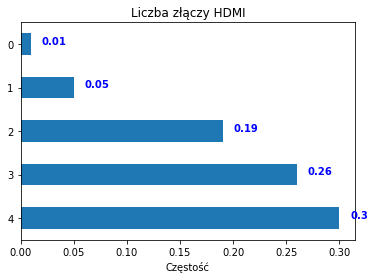

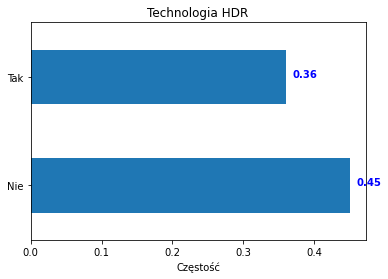

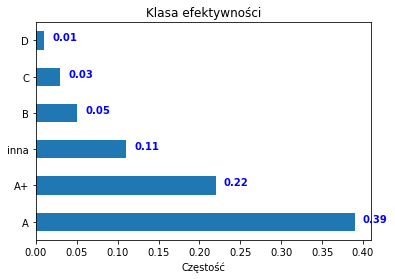

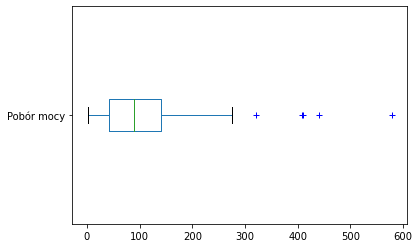

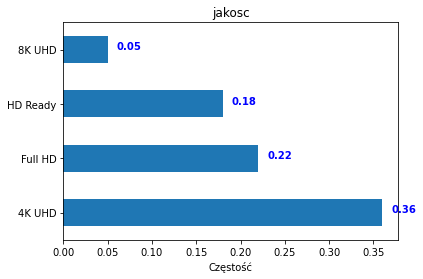

In [7]:
for column in df:
    try:
        ax = df[column].plot(kind = "box" ,vert = False , sym = "b+" )
        #print(df[column].describe())
        plt.savefig(f"figs/{column}.jpg")
        plt.show()
    except:
        TypeError
        ax = df[column].value_counts().div(100).plot(kind = "barh",title= column )
        #print(df[column].value_counts().div(100))
        ax.set_xlabel("Częstość")
        for i, v in enumerate(df[column].value_counts().div(100)):
             ax.text(v + 0.01, i , str(v), color='blue', fontweight='bold')
        plt.savefig(f"figs/{column}.jpg")
        plt.show()

In [20]:
#przygotwanie danych do regresji 
#usuniecie obserwacji odstajacych 
count = df["Cena"]
kwartyl = count.quantile(0.85)
drogie  = count > kwartyl
df = df.drop(drogie.loc[drogie].index)


regresion_data = pd.get_dummies(df, drop_first=True)

<h3>Macierz korelacji 

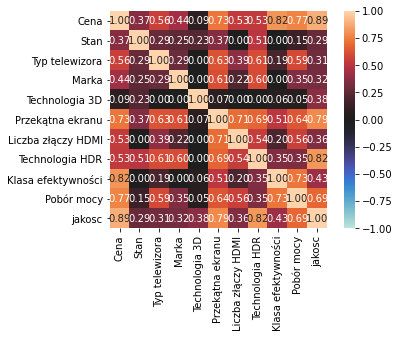

{'corr':                         Cena      Stan  Typ telewizora     Marka  \
 Cena                1.000000  0.370994        0.560352  0.444988   
 Stan                0.370994  1.000000        0.287485  0.251870   
 Typ telewizora      0.560352  0.287485        1.000000  0.289917   
 Marka               0.444988  0.251870        0.289917  1.000000   
 Technologia 3D      0.092826  0.232639        0.000000  0.000000   
 Przekątna ekranu    0.726724  0.365525        0.627738  0.610173   
 Liczba złączy HDMI  0.534192  0.000000        0.390523  0.216640   
 Technologia HDR     0.527593  0.507190        0.608284  0.603186   
 Klasa efektywności  0.818366  0.000000        0.193944  0.000000   
 Pobór mocy          0.767032  0.146485        0.594755  0.351934   
 jakosc              0.885042  0.285228        0.310567  0.323153   
 
                     Technologia 3D  Przekątna ekranu  Liczba złączy HDMI  \
 Cena                      0.092826          0.726724            0.534192   
 Stan   

In [10]:

associations(df,nan_strategy= "drop_features")

<h3>Model liniowy



In [21]:
regresion_data = regresion_data.sort_values(by= ["Cena"])
Y = regresion_data["Cena"]
Y = Y
X = regresion_data.iloc[:,1:]
X = sm.add_constant(X).astype(float)

model = sm.OLS(Y,X)
result = model.fit()

result.summary()
	

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Cena   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     25.97
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           3.85e-18
Time:                        12:08:44   Log-Likelihood:                -480.34
No. Observations:                  69   AIC:                             1017.
Df Residuals:                      41   BIC:                             1079.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -4088.0658    809.612     -5.049      0.000   -5723.111   -2453.021
Przekątna ekranu           60.7668      7.348      8.270      0.000      45.928      75.606
Pobór mocy                  1.8394      1.097      1.676      0.101      -0.377       4.055
Stan_Po zwrocie          -314.5068    282.742     -1.112      0.272    -885.516     256.503
Stan_Powystawowy          270.6042    270.461      1.001      0.323    -275.602     816.811
Stan_Używany             -238.5815    153.307     -1.556      0.127    -548.191      71.028
Typ telewizora_LED        293.9459    207.938      1.414      0.165    -125.993     713.885
Typ telewizora_OLED        86.3798    470.001      0.184      0.855    -862.807    1035.567
Typ telewizora_QLED      1154.6811    316.368      3.650      0.001     515.764    1793.598
Typ telewizora_inny      1088.2780    438.744      2.480      0.017     202.217    1974.339
Typ telewizora_plazmowy  -120.4638    356.232     -0.338      0.737    -839.889     598.962
Marka_LG                  180.8326    231.579      0.781      0.439    -286.851     648.517
Marka_Philips             -22.6238    288.185     -0.079      0.938    -604.626     559.378
Marka_Samsung             167.5581    241.804      0.693      0.492    -320.775     655.891
Marka_Sony                198.2230    259.098      0.765      0.449    -325.037     721.483
Marka_inna                 24.4852    188.253      0.130      0.897    -355.700     404.671
Technologia 3D_True       261.5398    244.528      1.070      0.291    -232.294     755.373
Liczba złączy HDMI_1     2763.3999    583.705      4.734      0.000    1584.584    3942.216
Liczba złączy HDMI_2     1942.3042    527.961      3.679      0.001     876.065    3008.543
Liczba złączy HDMI_3     2050.1284    521.865      3.928      0.000     996.201    3104.056
Liczba złączy HDMI_4     2029.2714    555.447      3.653      0.001     907.523    3151.020
Technologia HDR_Tak       203.4180    204.962      0.992      0.327    -210.511     617.347
Klasa efektywności_A+      61.5171    108.275      0.568      0.573    -157.148     280.182
Klasa efektywności_B     -330.8153    393.588     -0.841      0.405   -1125.683     464.052
Klasa efektywności_C      368.1309    481.743      0.764      0.449    -604.770    1341.031
Klasa efektywności_D     1.313e-12   1.15e-12      1.142      0.260   -1.01e-12    3.63e-12
Klasa efektywności_inna    55.0943    176.176      0.313      0.756    -300.701     410.890
jakosc_8K UHD                    0          0        nan        nan           0           0
jakosc_Full HD             10.6667    184.315      0.058      0.954    -361.566     382.899
jakosc_HD Ready           311.1711    229.798      1.354      0.183    -152.916     775.258
===============================================

<h3> Wstepna analiza modelu 

In [24]:
rs = sm.regression.linear_model.RegressionResults(model,result.params)
prstd, iv_l, iv_u = wls_prediction_std(result)
latex = (result.summary()).as_latex()
#with open("latex/initial_model.tex", "w") as f: 
  #  f.write(latex)




ValueError: need covariance of parameters for computing (unnormalized) covariances

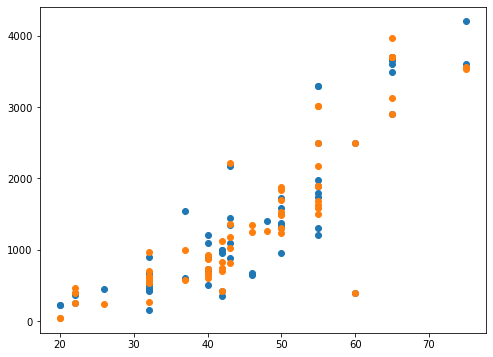

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X["Przekątna ekranu"],Y, "o" )
ax.plot(X["Przekątna ekranu"],result.fittedvalues, 'o')


In [27]:
stan_f = "(Stan_Używany = Stan_Powystawowy = Stan_Po zwrocie )"
typ_f = "(Typ telewizora_LED = Typ telewizora_OLED = Typ telewizora_QLED = Typ telewizora_inny = Typ telewizora_plazmowy = 0)"
marka_f = "(Marka_LG=Marka_Philips=Marka_Samsung= Marka_Sony=Marka_inna =0)"
hdmi_f = "(Liczba złączy HDMI_1=Liczba złączy HDMI_2=Liczba złączy HDMI_3=Liczba złączy HDMI_4=0)"
klasa_f = "(Klasa efektywności_A+ =Klasa efektywności_B = Klasa efektywności_C = Klasa efektywności_D=Klasa efektywności_inna=0)"
jakosc_f = "(jakosc_Full HD= jakosc_HD Ready = 0)"

testy_f = [stan_f,typ_f,marka_f,hdmi_f,klasa_f,jakosc_f]
wynik_ftest = []
for test in testy_f:
    wynik = result.f_test(test)
    name = test[1:].split(sep = "_")[0]
    s = f"{name} nie jest znacząca"
    s1 = f"{name} jest znaczące"
    wynik_ftest.append((name,True if wynik.pvalue < 0.05 else False))
    print(f"{s1 if wynik.pvalue < 0.05 else s}")



Stan nie jest znacząca
Typ telewizora jest znaczące
Marka nie jest znacząca
Liczba złączy HDMI jest znaczące
Klasa efektywności nie jest znacząca
jakosc nie jest znacząca


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)


<h3> Poprawki do model</h3>

*  Ucuniecie zmiennych nie znaczacych 
*  

<h3> Wybór modelu 


<h3>Testowanie Modelu oraz Pełny opis</h3>

*  Współczynnik determinacji.
*  Efekt katalizy.
*  Normalność rozkładu składnika losowego.
*  Istotność zmiennych.
*  Testy dodanych (pominiętych zmiennych).
*  Obserwacje odstające.
*  Test liczby serii (uporządkować obserwacje!!).
*  Test RESET.19.Testowanie heteroskeastyczności.
*  Test Chowa (wraz z komentarzem na temat podziału próbki na dwie grupy).
*  Współliniowość.
*  Koincydencja.
*  Interpretacja parametrów modelu (tam gdzie trzeba elastyczność).
*  redykcjawraz z 95% przedziałem ufności.
